## Import Packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import fbeta_score, f1_score

In [4]:
# read
df = pd.read_csv('../data/5guys_flight_data_preprocessed.csv')
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_DEL15,CRS_ELAPSED_TIME,CARRIER_NAME,...,PREVIOUS_AIRPORT,AWND,PRCP,TAVG,WDF2,WSF2,WT03,WT08,DEL_ORIGIN_COUNT,WT_FOG
0,0,27,0,182,14,12,1028,1.0,1.690223,15,...,53,1.214051,1.235494,-2.485781,1.0097,1.085395,-0.376401,2.327994,2.196709,1
1,0,27,0,2365,14,3,1011,1.0,0.255376,15,...,53,1.214051,1.235494,-2.485781,1.0097,1.085395,-0.376401,2.327994,2.196709,1
2,0,27,0,1481,14,6,600,1.0,0.308031,15,...,53,1.214051,1.235494,-2.485781,1.0097,1.085395,-0.376401,2.327994,2.196709,1
3,0,27,0,2401,14,3,851,0.0,0.255376,15,...,53,1.214051,1.235494,-2.485781,1.0097,1.085395,-0.376401,2.327994,2.196709,1
4,0,27,0,2941,14,12,754,1.0,1.729714,15,...,53,1.214051,1.235494,-2.485781,1.0097,1.085395,-0.376401,2.327994,2.196709,1


Epoch 1/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6604 - accuracy: 0.6035 - val_loss: 0.6615 - val_accuracy: 0.5985
Epoch 2/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6593 - accuracy: 0.6044 - val_loss: 0.6586 - val_accuracy: 0.6035
Epoch 3/10
5773/5773 [==============================] - 51s 9ms/step - loss: 0.6652 - accuracy: 0.6004 - val_loss: 0.6592 - val_accuracy: 0.6064
Epoch 4/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6729 - accuracy: 0.5946 - val_loss: 0.6848 - val_accuracy: 0.5989
Epoch 5/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6818 - accuracy: 0.5905 - val_loss: 0.6955 - val_accuracy: 0.5976
Epoch 6/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6922 - accuracy: 0.5863 - val_loss: 0.6578 - val_accuracy: 0.6039
Epoch 7/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.7096 - accuracy: 0.5825 - val_loss: 0.7080 - val_ac

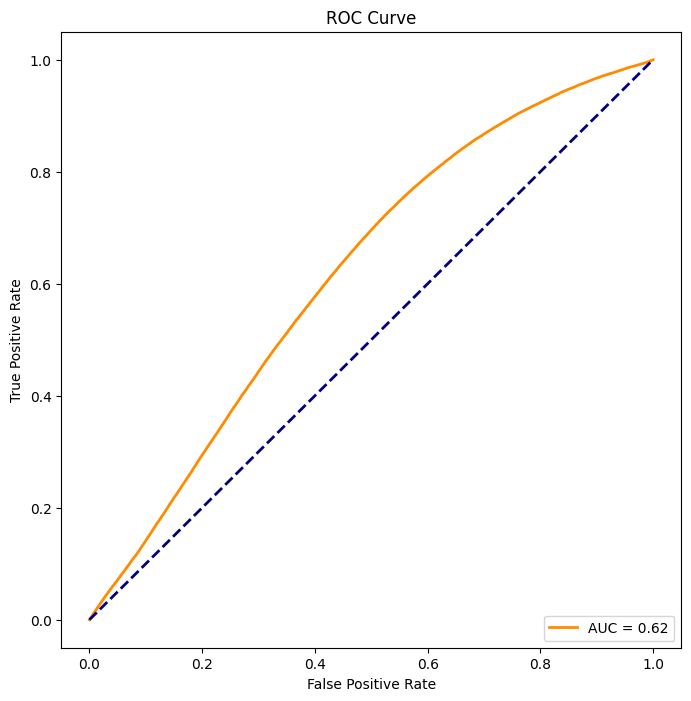

Accuracy: 0.5681272846133306
Confusion Matrix:
[[243177 197234]
 [ 37288  65336]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.55      0.67    440411
         1.0       0.25      0.64      0.36    102624

    accuracy                           0.57    543035
   macro avg       0.56      0.59      0.52    543035
weighted avg       0.75      0.57      0.61    543035



In [10]:
# Assuming df is your DataFrame with features and labels, and the label column is named 'target'
# X contains your features (all columns except 'target'), y contains your labels ('target')

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Build a simple neural network
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_resampled.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))  # Adding one more hidden layer
model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, stratify=y_train_resampled,random_state=42)
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val), verbose=1)

# Make predictions on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
#plt.figure(figsize=(6, 6))
#plot_confusion_matrix(model, X_test_scaled, y_test, display_labels=['Not Delayed', 'Delayed'])
#plt.title('Confusion Matrix (After Undersampling)')
#plt.show()

Epoch 1/25
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6668 - accuracy: 0.5991 - val_loss: 0.6662 - val_accuracy: 0.5954
Epoch 2/25
5773/5773 [==============================] - 54s 9ms/step - loss: 0.7044 - accuracy: 0.5814 - val_loss: 0.9056 - val_accuracy: 0.5532
Epoch 3/25
5773/5773 [==============================] - 54s 9ms/step - loss: 0.7844 - accuracy: 0.5677 - val_loss: 0.9681 - val_accuracy: 0.5491
Epoch 4/25
5773/5773 [==============================] - 54s 9ms/step - loss: 0.9658 - accuracy: 0.5556 - val_loss: 0.9040 - val_accuracy: 0.5781
Epoch 5/25
5773/5773 [==============================] - 50s 9ms/step - loss: 1.2938 - accuracy: 0.5479 - val_loss: 0.7541 - val_accuracy: 0.5878
Epoch 6/25
5773/5773 [==============================] - 48s 8ms/step - loss: 1.6430 - accuracy: 0.5434 - val_loss: 1.8618 - val_accuracy: 0.5791
Epoch 7/25
5773/5773 [==============================] - 45s 8ms/step - loss: 2.1770 - accuracy: 0.5409 - val_loss: 3.3554 - val_ac

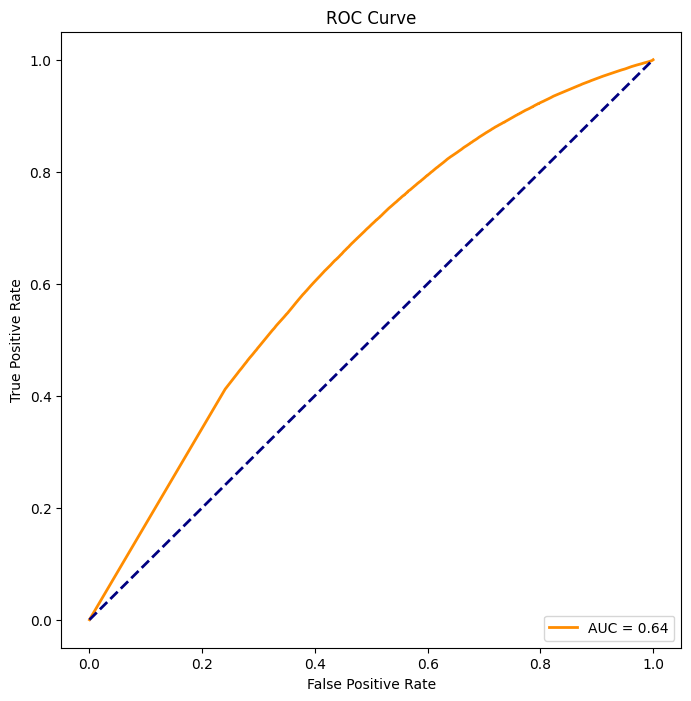

Accuracy: 0.5819072435478376
Confusion Matrix:
[[250651 189760]
 [ 37279  65345]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.57      0.69    440411
         1.0       0.26      0.64      0.37    102624

    accuracy                           0.58    543035
   macro avg       0.56      0.60      0.53    543035
weighted avg       0.75      0.58      0.63    543035



In [7]:
# Assuming df is your DataFrame with features and labels, and the label column is named 'target'
# X contains your features (all columns except 'target'), y contains your labels ('target')

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Build a simple neural network
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_resampled.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))  # Adding one more hidden layer
model.add(Dense(1, activation='sigmoid'))


# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, stratify=y_train_resampled,random_state=42)
history = model.fit(X_train, y_train, epochs=25, batch_size=256, validation_data=(X_val, y_val), verbose=1)

# Make predictions on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
#plt.figure(figsize=(6, 6))
#plot_confusion_matrix(model, X_test_scaled, y_test, display_labels=['Not Delayed', 'Delayed'])
#plt.title('Confusion Matrix (After Undersampling)')
#plt.show()


Epoch 1/10
12828/12828 [==============================] - 225s 17ms/step - loss: 0.6625 - accuracy: 0.6021 - val_loss: 0.6515 - val_accuracy: 0.5948
Epoch 2/10
12828/12828 [==============================] - 223s 17ms/step - loss: 0.6620 - accuracy: 0.6022 - val_loss: 0.6316 - val_accuracy: 0.6266
Epoch 3/10
12828/12828 [==============================] - 207s 16ms/step - loss: 0.6619 - accuracy: 0.6024 - val_loss: 0.6735 - val_accuracy: 0.5653
Epoch 4/10
12828/12828 [==============================] - 204s 16ms/step - loss: 0.6621 - accuracy: 0.6022 - val_loss: 0.6653 - val_accuracy: 0.5745
Epoch 5/10
12828/12828 [==============================] - 204s 16ms/step - loss: 0.6622 - accuracy: 0.6022 - val_loss: 0.6629 - val_accuracy: 0.5792
Epoch 6/10
12828/12828 [==============================] - 204s 16ms/step - loss: 0.6620 - accuracy: 0.6024 - val_loss: 0.6628 - val_accuracy: 0.5790
Epoch 7/10
12828/12828 [==============================] - 204s 16ms/step - loss: 0.6619 - accuracy: 0.6023

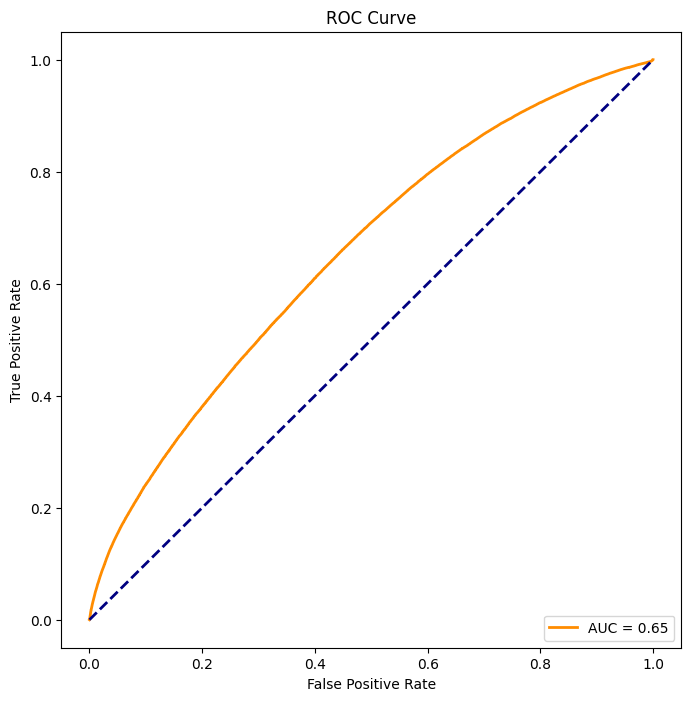

Accuracy: 0.5923319859677553
Confusion Matrix:
[[257360 183051]
 [ 38327  64297]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.58      0.70    440411
         1.0       0.26      0.63      0.37    102624

    accuracy                           0.59    543035
   macro avg       0.57      0.61      0.53    543035
weighted avg       0.76      0.59      0.64    543035



In [11]:
# Assuming df is your DataFrame with features and labels, and the label column is named 'target'
# X contains your features (all columns except 'target'), y contains your labels ('target')

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

# Remove 'TMAX' and 'distance' from the list of features
features_to_exclude = ['TMAX', 'distance']
features = [feature for feature in features if feature not in features_to_exclude]

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Build a simple neural network
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train_resampled.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.02), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=128, validation_data=(X_val, y_val), verbose=1)

# Make predictions on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
#plt.figure(figsize=(6, 6))
#plot_confusion_matrix(model, X_test_scaled, y_test, display_labels=['Not Delayed', 'Delayed'])
#plt.title('Confusion Matrix (After Undersampling)')
#plt.show()

Epoch 1/20
12828/12828 [==============================] - 530s 41ms/step - loss: 0.6470 - accuracy: 0.6237 - val_loss: 0.6246 - val_accuracy: 0.6534
Epoch 2/20
12828/12828 [==============================] - 519s 40ms/step - loss: 0.6309 - accuracy: 0.6392 - val_loss: 0.6335 - val_accuracy: 0.6422
Epoch 3/20
12828/12828 [==============================] - 494s 38ms/step - loss: 0.6263 - accuracy: 0.6444 - val_loss: 0.6357 - val_accuracy: 0.6455
Epoch 4/20
12828/12828 [==============================] - 521s 41ms/step - loss: 0.6237 - accuracy: 0.6465 - val_loss: 0.6230 - val_accuracy: 0.6581
Epoch 5/20
12828/12828 [==============================] - 524s 41ms/step - loss: 0.6223 - accuracy: 0.6480 - val_loss: 0.6151 - val_accuracy: 0.6706
Epoch 6/20
12828/12828 [==============================] - 519s 40ms/step - loss: 0.6208 - accuracy: 0.6495 - val_loss: 0.6240 - val_accuracy: 0.6495
Epoch 7/20
12828/12828 [==============================] - 519s 40ms/step - loss: 0.6199 - accuracy: 0.6502

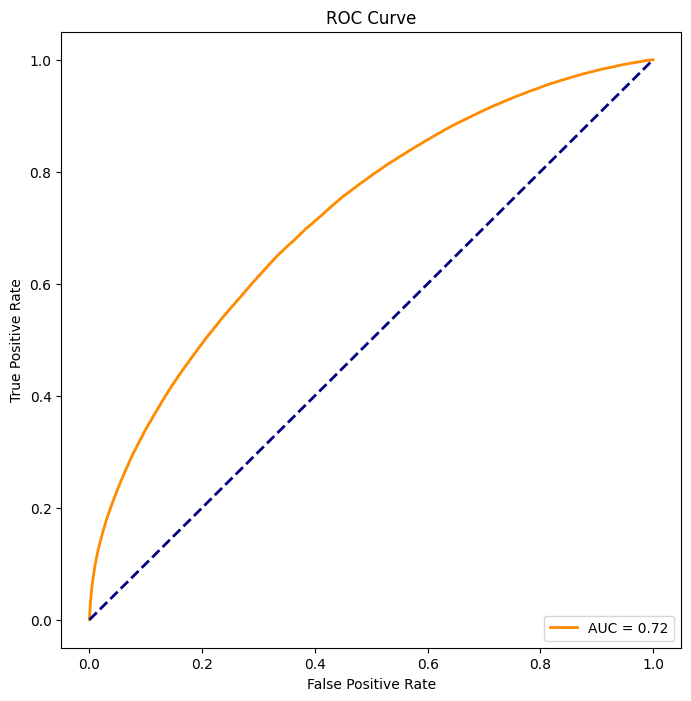

Accuracy: 0.6855506551143112
Confusion Matrix:
[[309713 130698]
 [ 40059  62565]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.70      0.78    440411
         1.0       0.32      0.61      0.42    102624

    accuracy                           0.69    543035
   macro avg       0.60      0.66      0.60    543035
weighted avg       0.78      0.69      0.72    543035



In [37]:
# Assuming df is your DataFrame with features and labels, and the label column is named 'target'
# X contains your features (all columns except 'target'), y contains your labels ('target')

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Reshape data for LSTM
X_train_reshaped = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build an improved LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(1, X_train_resampled.shape[1]), return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train_resampled, epochs=20, batch_size=128, validation_data=(X_val_reshaped, y_val), verbose=1)

# Make predictions on the test set
y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

In [13]:
# Calculate additional metrics
#f2 score combines recall and precision with weighting 
#In this case, with β=2, more emphasis is placed on recall than precision.
f2 = fbeta_score(y_test, y_pred, beta=2)

f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'F2 Score: {f2}')
print(f'F1 Micro: {f1_micro}')
print(f'F1 Macro: {f1_macro}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

Accuracy: 0.6668870330641672
F2 Score: 0.5162381728565028
F1 Micro: 0.6668870330641672
F1 Macro: 0.590167631229872
Confusion Matrix:
[[298547 141864]
 [ 39028  63596]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.68      0.77    440411
         1.0       0.31      0.62      0.41    102624

    accuracy                           0.67    543035
   macro avg       0.60      0.65      0.59    543035
weighted avg       0.78      0.67      0.70    543035



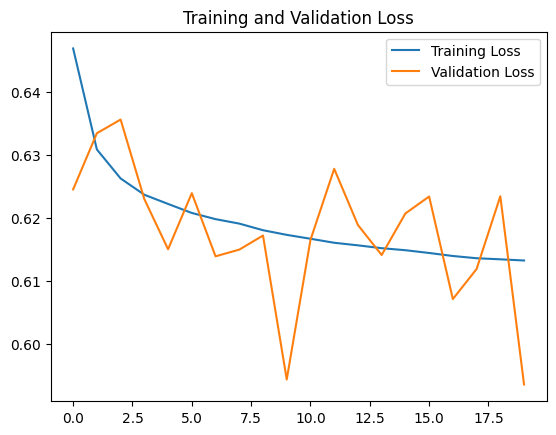

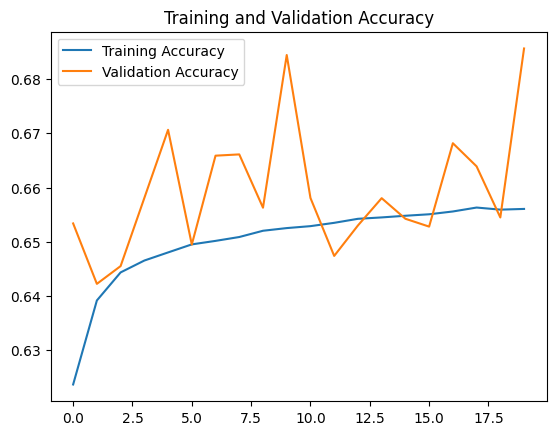

In [38]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Epoch 1/20
12828/12828 [==============================] - 710s 55ms/step - loss: 0.6971 - accuracy: 0.5900 - val_loss: 0.6397 - val_accuracy: 0.6294
Epoch 2/20
12828/12828 [==============================] - 676s 53ms/step - loss: 0.6397 - accuracy: 0.6295 - val_loss: 0.6294 - val_accuracy: 0.6499
Epoch 3/20
12828/12828 [==============================] - 659s 51ms/step - loss: 0.6328 - accuracy: 0.6373 - val_loss: 0.6265 - val_accuracy: 0.6550
Epoch 4/20
12828/12828 [==============================] - 708s 55ms/step - loss: 0.6287 - accuracy: 0.6417 - val_loss: 0.6220 - val_accuracy: 0.6606
Epoch 5/20
12828/12828 [==============================] - 733s 57ms/step - loss: 0.6254 - accuracy: 0.6456 - val_loss: 0.6172 - val_accuracy: 0.6662
Epoch 6/20
12828/12828 [==============================] - 688s 54ms/step - loss: 0.6226 - accuracy: 0.6484 - val_loss: 0.6203 - val_accuracy: 0.6640
Epoch 7/20
12828/12828 [==============================] - 737s 57ms/step - loss: 0.6204 - accuracy: 0.6515

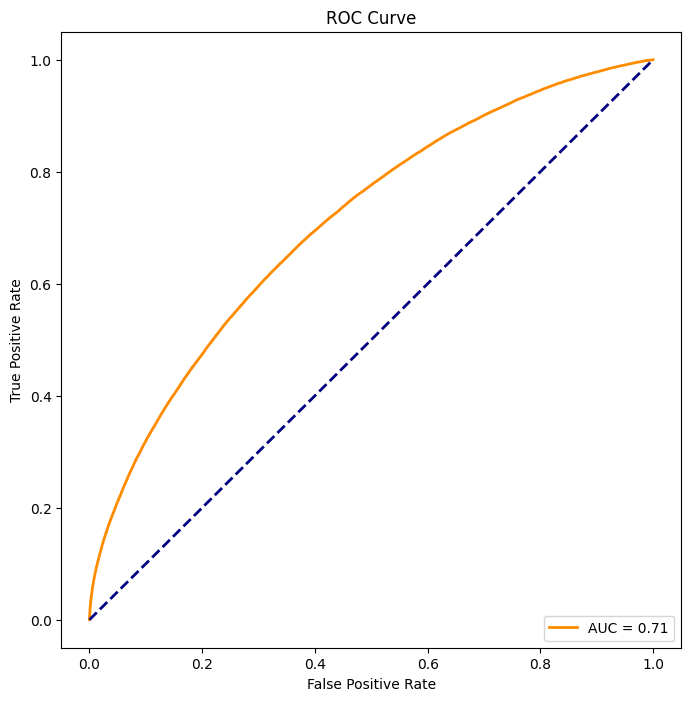

Accuracy: 0.6668870330641672
Confusion Matrix:
[[298547 141864]
 [ 39028  63596]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.68      0.77    440411
         1.0       0.31      0.62      0.41    102624

    accuracy                           0.67    543035
   macro avg       0.60      0.65      0.59    543035
weighted avg       0.78      0.67      0.70    543035



In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


# Assuming df is your DataFrame with features and labels, and the label column is named 'target'
# X contains your features (all columns except 'target'), y contains your labels ('target')

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

# Remove 'TMAX' and 'distance' from the list of features
features_to_exclude = ['TMAX', 'distance']
features = [feature for feature in features if feature not in features_to_exclude]

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Reshape data for LSTM
X_train_reshaped = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build a super complex LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(1, X_train_resampled.shape[1]), return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_reshaped, y_train_resampled,
    epochs=20, batch_size=128,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)
# Make predictions on the test set
y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)
